## Shortest path relation extraction with word embeddings
Approach:
1. Search for Named Entities of type PERSON in sentence
2. Build undirected graph of the dependecy path
3. Search shortest path between each entity tuple
4. Store words appearing on shortest path
5. Get word embedding representation for each word on the shortest path (SP vectors)
6. Sum SP vectors to a single vector
7. Cluster vectors using hierarchical agglomerative clustering (HAC)

In [1]:
import enum
import networkx as nx
import spacy
import matplotlib.pyplot as plt
import logging
import pandas as pd
import numpy as np
import re

from networkx.exception import NodeNotFound, NetworkXNoPath
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

c:\program files\python\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Evaluation text

### 1. Self-created data

#### (DE)

In [23]:
lang = 'DE'
utterance1 = u'''Herbert ist der Vater von Hans'''
utterance2 = u'''Peter und Maria gehen morgen ins Kino'''
utterance3 = u'''Herbert sein Sohn und ich gehen heute ins Kino'''
utterance4 = u'''Ich gehe mit Johann in den Zoo'''
utterance5 = u'''Hans und sein Sohn Hubert gehen in den Zoo.'''
utterance6 = u'''Hans, welcher der Sohn von Hubert ist, geht mit Peter ins Kino.'''
utterance7 = u'''Meine kleine Enkelin Lisa und mein Enkel Lukas fliegen morgen nach London.'''
utterance8 = u'''Ich fahre mit meinen Enkeln Lukas und Lisa in den Urlaub.'''
utterance9 = u'''Potesters seized several pumping stations, holding 127 Shell workers hostage.'''
utterance10 = u'''Troops recently have raided churches, warning ministers to stop preaching.'''
multi_utterances = u'''Homer und sein Sohn Peter gehen mit Milhouse ins Kino. Ich gehe mit Bart laufen.
Meine Enkelin Lisa und mein Enkel Peter fliegen morgen nach London. Ned Flanders ist der Vater von Rod und Todd. 
Homer fährt mit seiner Tochter Lisa zum See. Homer fährt mit seiner Tochter Lisa zum See. Ich habe 3 Geschwister. 
Ich habe einen Bruder.'''

text = multi_utterances

#### (EN)

In [80]:
lang = 'EN'
utterance1 = u'''my boyfriend and i are moving into an apartment together next week. i've a children and a dogs.
                my sister Lindsey lives in New York. She works as a journalist. 
                i love going to the park with my three children and my wife.'''
utterance2 = u'''My sister Lindsey lives in New York.'''
utterance3 = u'''my father is an electrician. my father is a farmer.'''
utterance4 = u'''my boyfriend and i are moving into an apartment together next week.'''
utterance5 = u'''i've a children and a dogs.'''
utterance6 = u'''Hi! You're Homer's sister-in-law, right? I remember you, but I don't remember you being so beau'''
utterance7 = u'''Barack Obama is married to Michele Obama.'''
utterance8 = u'''I have two children. My daughter lives in Berlin, my son is studying in Munich.'''
utterance9 = u'''Peter is the fater of Tom.'''
utterance10 = u'''Peter, Tom's father, will pick us up today.'''
utterance11 = u'''My daughter Lisa is moving to London next month.'''

text = utterance11

### 2. Conversation Data from ConvAI coropus (EN)

#### First have a look at the data set and create a dataframe

In [2]:
import json
from pprint import pprint

with open('data/convai/export_2018-07-04_train.json', 'r') as f:
    data = json.load(f)

df_columns = ['sender', 'text']
df = pd.DataFrame(columns=df_columns)

for row in data:
    for dialog in row['dialog']:
        sender = dialog['sender_class']
        text = dialog['text']

        data = {'sender': sender, 'text': text}
        df = df.append(data, ignore_index=True)

df[:50]

KeyError: 'sender_class'

#### Extract human dialogs and store to text file

In [11]:
lang = 'EN'

human_conv = df.loc[df['sender'] == 'Human']

corpus = ''
for row in human_conv['text']:
    corpus += row.replace('\n', '') + ' '
  
text = corpus[:5000]

### 3. Simpsons conversations (EN)

In [69]:
lang = 'EN'
with open('data/simpsons_conversations.txt', 'r', encoding='utf-8') as f:
    data = f.read()
    data = data.replace('\n', ' ')
    
corpus = data[5000:10000]   

### 4. Book of Genesis (EN)

In [18]:
lang = 'EN'
with open('data/NETBible_Genesis.txt', 'r', encoding='utf-8') as f:
    data = f.read()
    
corpus = data[:1000]

### 5. Robinson Crusoe (DE)

In [45]:
lang = 'DE'
with open('data/Robinson_Crusoe_conversations.txt', 'r', encoding='utf-8') as f:
    data = f.read()
    
corpus = data[:1000]
corpus

'Was für andere Gründe, sagte er, als die bloße Vorliebe für ein unstetes Leben, können dich bewegen, Vaterhaus und Heimat verlassen zu wollen, wo du dein gutes Unterkommen hast und bei Fleiß und Ausdauer in ruhigem und behaglichem Leben dein Glück machen kannst.\nSie ist weder dem Elend und der Mühsal der nur von Händearbeit lebenden Menschenklasse ausgesetzt, noch wird sie von dem Hochmuth, der Ueppigkeit, dem Ehrgeiz und dem Neid, die in den höheren Sphären der Menschenwelt zu Hause sind, heimgesucht. Am besten, fügte er hinzu, kannst du die Glückseligkeit des Mittelstandes daraus erkennen, daß er von Allen, die ihm nicht angehören, beneidet wird.\nAuch der Weise bezeugt, daß jener Stand der des wahren Glückes ist, indem er betet: Armuth und Reichthum gib mir nicht.\nHabe nur darauf Acht, fuhr mein Vater fort, so wirst du finden, daß das Elend der Menschheit zumeist an die höheren und niederen Schichten der Gesellschaft vertheilt ist.\nDieser Weg führt vielmehr in gelassener Behagli

### 6. Winnetou Band 1 (DE)

In [65]:
lang = 'DE'
with open('data/Winnetou_Band1_conversations.txt', 'r', encoding='utf-8') as f:
    data = f.read()
    
corpus = data[:5000]
corpus

'\ufeffDiese Zurückhaltung schien ihm aber keineswegs lieb zu sein; ich erinnere mich noch heut des zornigen Gesichtes, welches er mir eines Abends, als ich zu ihm kam, zeigte, und des Tones, in welchem er mich empfing, ohne auf mein ›good evening‹ zu antworten: Wo habt Ihr denn gestern gesteckt, Sir? Zu Hause. Und vorgestern? Auch zu Hause. Macht mir doch nichts weis! Es ist wahr, Mr. Henry. Pshaw!\nSolche grüne Vögel, wie Ihr einer seid, bleiben nicht im Neste hocken; die stecken die Schnäbel überall hin, nur da nicht, wo sie hingehören! Und wo gehöre ich hin, wenn es Euch beliebt, es mir zu sagen? Hierher zu mir, verstanden!\nHabe Euch schon lange einmal nach etwas fragen wollen. Warum habt Ihr es nicht getan? Weil ich nicht wollte.\nHört Ihr es? Und wann wollt Ihr denn? Heute vielleicht. So fragt getrost nur zu, forderte ich ihn auf, indem ich mich hoch auf die Schraubenbank setzte, an welcher er arbeitete.\nAls ob ich so ein Greenhorn, wie Ihr seid, erst um Erlaubnis fragen müßte,

## Set language settings

In [47]:
if lang == 'DE':
    nlp = spacy.load('de') # for various nlp tasks (pos, ner, dep-path etc.)
    flair_ner_tagger_lang = 'de-ner'
    stop_words = set(stopwords.words('german'))
    stemmer_lang = 'german'
    
    relationship_list = ['vater', 'mutter', 'papa', 'papi', 'mama', 'mami', 'sohn', 'tochter', 'bruder', 'schwester', 
                         'enkel', 'enkelin', 'nichte', 'neffe', 'großvater', 'großmutter', 'opa', 'opa', 
                         'onkel', 'tante', 'cousin', 'cousine', 'schwager', 'schwägerin', 'mann', 'frau', 'ehemann', 'ehefrau']
    me_list = ['ich', 'mein', 'meine']
    
    grammar = r"""
            PP: {<PRON><AUX><DET><ADJ>?<NOUN>}
            NP: {<DET><ADJ>?<NOUN><PROPN>*}            
            REL: {<PP>|<NP>}"""
    
elif lang == 'EN':
    nlp = spacy.load('en')
    flair_ner_tagger_lang = 'ner'
    stop_words = set(stopwords.words('english'))
    stemmer_lang = 'english'
    
    relationship_list = ['father', 'mother', 'dad', 'daddy', 'mom', 'mommy', 'son', 'daughter', 'brother', 'sister', 
                         'grandchild', 'grandson', 'granddaughter', 'grandfather', 'grandmother', 
                         'grampa', 'grandpa', 'grandma', 'niece', 'nephew', 'uncle', 'aunt', 'cousin'
                        'brother-in-law', 'sister-in-law', 'husband', 'wife']
    me_list = ['i', 'my']
    
    grammar = r"""
                PP: {<PRON><VERB><DET><ADJ>?<NOUN>}
                NP: {<DET><ADJ>?<NOUN><PROPN>*}            
                REL: {<PP>|<NP>}"""

## Named Entity Recognition
choose one of the two below (default=Flair)

### 1. spaCy NER

In [48]:
doc = nlp(text)

In [74]:
entities = []
for ent in doc.ents:
    if ent.label_ == 'PER':
        entities.append(ent.text.lower())

for token in doc:
    if token.text.lower() in me_list:
        entities.append(token.text.lower())


### 2. Flair NER

In [67]:
import nltk
from flair.data import Sentence
from flair.models import SequenceTagger
from nltk.stem.wordnet import WordNetLemmatizer

#nltk.download('wordnet')
#lemmatizer = WordNetLemmatizer()

# PER-PER entities
def extract_per_to_per_entities(raw_sentence):
    entities = []
    
    clean_sentence = re.sub('\W+', ' ', raw_sentence) # remove non-word characters
    sentence = Sentence(clean_sentence)
    tagger = SequenceTagger.load(flair_ner_tagger_lang)
    tagger.predict(sentence) # run NER over sentence
    
    # NER spans
    for entity in sentence.get_spans('ner'):
        print('Extracting entities...')
        print(f'Entity: {entity}')

        if entity.tag == 'PER':
            if len(entity.tokens) > 1:  # if it is a multi word entity, replace blanks with underscores 
                entities.append(str(entity.text.lower()).replace(' ', '_'))
            else:
                entities.append(entity.text.lower())
    
    # check for personal pronoun in sentence
    for token in sentence:
        lemmatized_entity = lemmatizer.lemmatize(token.text.lower())
        
        if token.text.lower() in me_list:
            entities.append(token.text.lower())
                
    # check for me or relationship
    # Lemmatization
    #if len(entities) == 0:
    #    for token in sentence:
    #        lemmatized_entity = lemmatizer.lemmatize(token.text.lower())

    #        if token.text.lower() in me_list or lemmatized_entity in relationship_list:
    #            entities.append(token.text.lower())

    # NER tag for each token
    #for token in sentence:
    #    ner_tag = token.get_tag('ner')
    #    print(f'{token}, {ner_tag}')

    return entities

## Build undirected graph

In [60]:
def build_undirected_graph(sentence, plot=False):
    doc = nlp(sentence)
    edges = []
    for token in doc:
        for child in token.children:
            edges.append((f'{token.lower_}',
                          f'{child.lower_}'))
    graph = nx.Graph(edges)
    if plot:
        plot_graph(graph)
        
    return graph

In [61]:
def plot_graph(graph):
    # nx.draw_networkx(graph, node_size=100, ode_color=range(len(graph)))
    pos = nx.spring_layout(graph)  # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=200)
    # edges
    nx.draw_networkx_edges(graph, pos, width=1)
    # labels
    nx.draw_networkx_labels(graph, pos, font_size=12, font_family='sans-serif')

    plt.axis('off')  # disable axis
    plt.show()

## Shortest Dependency Path
Find shortest dependency path between every found two entities in a sentence

In [76]:
path_dict = {}

def search_shortest_dep_path(entities, sentence):
    print(f'Searching shortest path between entities: {entities}')
    graph = build_undirected_graph(sentence, plot=True)

    for i, first_entity in enumerate(entities):
        first_entity = first_entity.split('_')[0]  # use only first name of multi-word entities

        for j in range(len(entities)):  # bidirectional relations
        #for j in range(i+1, len(entities)):  # unidirectional relations
            second_entity = entities[j]
            second_entity = second_entity.split('_')[0]  # use only first name of multi-word entities
            print(first_entity, second_entity)
            
            if not i == j and second_entity not in me_list:        
                try:
                    shortest_path = nx.shortest_path(graph, source=first_entity, target=second_entity)
                    key = first_entity + '-' + second_entity
                    #path_dict[key] = shortest_path  # include entities in sp
                    path_dict[key] = shortest_path[1:-1]  # exclude entities in sp
                except NodeNotFound as err:
                    logging.warning(f'Node not found: {err}')
                except NetworkXNoPath as err:
                    logging.warning(f'No path found: {err}')
    #else:
    #    print('No persons found in sentence')
    
    return path_dict


### Lexical analysis (based on ReVerb)

In [71]:
def search_rel_type(sentence):
    for token in word_tokenize(sentence):
        if token.lower() in relationship_list:
            return token.lower()

    return None


def pos_tag_sentence(sentence):
    sentence = re.sub('\W+', ' ', sentence)
    doc = nlp(sentence)

    pos_tagged_sentence = []
    for token in doc:
        pos_tuple = (token.text, token.pos_)
        pos_tagged_sentence.append(pos_tuple)

    return pos_tagged_sentence


def chunk_sentence(pos_tagged_sentence):
    cp = nltk.RegexpParser(grammar)
    result = cp.parse(pos_tagged_sentence)

    return result


def extract_rel(sentence):
    me = None

    relative = search_rel_type(sentence)
    if relative:
        chunk_tree = chunk_sentence(pos_tag_sentence(sentence))

        for i, sub_tree in enumerate(chunk_tree):
            if type(sub_tree) is nltk.tree.Tree and sub_tree.label() == 'REL':
                me = sub_tree[0][0][0]

    return me, relative


extract_rel('My daughter lives in Berlin')

(None, 'daughter')

## Extraction relations
* if PER-PER in sentence, use shortest dependency path to extract the features in between
* if not PER-PER in senctence, find description of a user related person through lexical analysis

##> Processing sentence: "My daughter Lisa is moving to London next month."
Extracting entities...
Entity: PER-span [3]: "Lisa"
Extracting entities...
Entity: LOC-span [7]: "London"
lemmatized: my
lemmatized: daughter
lemmatized: lisa
lemmatized: is
lemmatized: moving
lemmatized: to
lemmatized: london
lemmatized: next
lemmatized: month
Entities found: ['lisa', 'my']
Searching shortest path between entities: ['lisa', 'my']


c:\program files\python\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


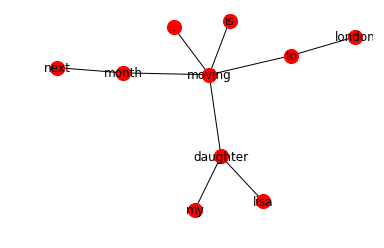

lisa lisa
lisa my
my lisa
my my
Paths: {'my-lindsey': ['sister'], 'my-lisa': ['daughter']}


In [81]:
for sentence in sent_tokenize(text):
    print(f'##> Processing sentence: "{sentence}"')
    entities = extract_per_to_per_entities(sentence)
    
    if entities:
        print(f'Entities found: {entities}')
        paths = search_shortest_dep_path(entities, sentence)
        print(f'Paths: {paths}')
    else:
        me_rels = extract_rel(sentence)
        print(me_rels)
            

## Feature Extraction

In [134]:
feature_columns = ['m1', 'm2', 'm1_pos', 'm2_pos', 'before_m1', 'after_m2', 'between_words', 
                   'short_path', 'm1_head', 'm2_head']

features = pd.DataFrame(columns=feature_columns)

In [135]:
features_list = []  # for TF-IDF vectorization
#ners = []

# check for named entity 'PER' or 'PME' in each sentence
#for ner_tuple in ner_tuples:
#    if 'I-PER' in ner_tuple:
#        ners.append(ner_tuple)
#    elif ner_tuple[0].lower() in me_list:
#        ners.append((ner_tuple[0], 'PME'))
#    elif ner_tuple[0].lower() in relationship_list:
#        ners.append((ner_tuple[0], 'SOC'))

for sentence in sent_tokenize(text):
    sentence = re.sub(r'\W+', ' ', sentence.lower()) # remove non-word characters
    print(sentence)
    doc = nlp(sentence)
    
    for key, value in path_dict.items():
        # extract entities
        m1 = key.split('-')[0]
        m2 = key.split('-')[1]

        short_path = value

        # POS tagging and head
        for token in doc:
            if token.text.lower() == m1:
                m1_pos_tag = token.pos_
                m1_head = token.head.text
                #m1_children = [child for child in token.children]
            elif token.text.lower() == m2:
                m2_pos_tag = token.pos_
                m2_head = token.head.text
                #m2_children = [child for child in token.children]

        # Dependecy parsing
        #dep_path = []
        #for chunk in doc.noun_chunks:
        #    if chunk.root.text.lower() == m1 or chunk.root.text.lower() == m2:
        #        dep_path.append([chunk.root.text, chunk.root.dep_, chunk.root.head.text])  

        # Between words
        start_position_m1 = sentence.find(m1)
        start_position_m2 = sentence.find(m2)

        # verify if the words were found in the sentence
        if not start_position_m1 == -1 and not start_position_m2 == -1:
            start_position_between = start_position_m1 + len(m1) + 1
            end_position_between = start_position_m2

            between = sentence[start_position_between:end_position_between]
            between_words = []
            for word in word_tokenize(between):
                between_words.append(word)

            beforeM1 = sentence[:start_position_m1 - 1]
            afterM2 = sentence[start_position_m2 + len(m2):]

            beforeM1_list = word_tokenize(beforeM1)
            afterM2_list = word_tokenize(afterM2)

            data = {'m1': m1, 'm2': m2, 'm1_pos': m1_pos_tag, 'm2_pos': m2_pos_tag,
                    'before_m1': beforeM1_list, 'after_m2': afterM2_list,
                    'between_words': between_words, 'short_path': short_path,
                     'm1_head': m1_head, 'm2_head': m2_head}

            training_example = pd.Series(data, index=feature_columns)
            features = features.append(training_example, ignore_index=True)
            #context = [beforeM1, between, afterM2]
            #features_list.append(context)

#features_list

homer und sein sohn peter gehen mit milhouse ins kino 
ich gehe mit bart laufen 
meine enkelin lisa und mein enkel peter fliegen morgen nach london 
ned flanders ist der vater von rod und todd 
homer fährt mit seiner tochter lisa zum see 


In [136]:
features

,m1,m2,m1_pos,m2_pos,before_m1,after_m2,between_words,short_path,m1_head,m2_head
0,homer,peter,ADJ,ADJ,"[homer, und, sein, sohn, peter, gehen, mit, mi...","[gehen, mit, milhouse, ins, kino]","[und, sein, sohn]","[und, sohn]",gehen,gehen
1,homer,milhouse,ADJ,ADJ,"[homer, und, sein, sohn, peter, gehen, mit, mi...","[ins, kino]","[und, sein, sohn, peter, gehen, mit]","[gehen, mit]",gehen,mit
2,peter,milhouse,ADJ,ADJ,"[homer, und, sein, sohn]","[ins, kino]","[gehen, mit]","[sohn, und, homer, gehen, mit]",gehen,mit
3,lisa,peter,VERB,ADJ,"[meine, enkelin]","[fliegen, morgen, nach, london]","[und, mein, enkel]","[und, enkel]",meine,und
4,ned,rod,X,X,"[ned, flanders, ist, der, vater, von, rod, und...","[und, todd]","[flanders, ist, der, vater, von]","[flanders, ist, vater, von]",flanders,von
5,ned,todd,X,ADJ,"[ned, flanders, ist, der, vater, von, rod, und...",[],"[flanders, ist, der, vater, von, rod, und]","[flanders, ist, vater, von, rod, und]",flanders,und
6,rod,todd,X,ADJ,"[ned, flanders, ist, der, vater, von]",[],[und],[und],von,und
7,homer,lisa,ADV,X,"[homer, fährt, mit, seiner, tochter, lisa, zum...","[zum, see]","[fährt, mit, seiner, tochter]","[fährt, mit, tochter]",fährt,mit


In [137]:
vector_feature_columns = ['m1', 'm2', 'short_path_vector', 'm1_head', 'm2_head']
vector_features = pd.DataFrame(columns=vector_feature_columns)

## Word Embeddings of the words inside the shortest path and sum them into a single vector
* Two Representations: GermanWordEmbeddings and Flair Word Embeddings
Choose one of the two below

### 1. GermanWordEmbeddings https://github.com/devmount/GermanWordEmbeddings

In [42]:
ger_model = KeyedVectors.load_word2vec_format('../models/german.model', binary=True)

embedding_vectors = []
# get vector length
vector_len = len(ger_model.wv['hallo'])

for row in features.iterrows():
    m1 = row[1]['m1']
    m2 = row[1]['m2']
    short_path = row[1]['short_path']
    
    # get the word embedding representation for each word in the shortest path
    #row_embeddings = np.empty(len(short_path))
    row_embeddings = []
    
    for word in short_path:
        try:
            row_embeddings.append(ger_model.wv[word])
        except KeyError as err:
            print(err)
            row_embeddings.append(np.zeros(vector_len))
    
    #print(sum(row_embeddings))
    embedding_vectors.append(sum(row_embeddings))
    vector_data = {'m1': m1, 'm2': m2, 'short_path_embedding_vector': sum(row_embeddings)}
    training_example = pd.Series(vector_data, index=vector_feature_columns)
    vector_features = vector_features.append(training_example, ignore_index=True)

# summarize vectors    
#row_embeddings.sum()
vector_features


c:\program files\python\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files\python\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


"word 'homer' not in vocabulary"
"word 'mit' not in vocabulary"
"word 'milhouse' not in vocabulary"
"word 'flanders' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'von' not in vocabulary"
"word 'flanders' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'von' not in vocabulary"
"word 'und' not in vocabulary"
"word 'todd' not in vocabulary"
"word 'und' not in vocabulary"
"word 'todd' not in vocabulary"
"word 'homer' not in vocabulary"
"word 'fährt' not in vocabulary"
"word 'mit' not in vocabulary"
"word 'tochter' not in vocabulary"
"word 'lisa' not in vocabulary"


,m1,m2,short_path_vector
0,homer,milhouse,NaN
1,ned,rod,NaN
2,ned,todd,NaN
3,rod,todd,NaN
4,homer,lisa,NaN


### 2. Flair Word Embeddings  https://github.com/zalandoresearch/flair

In [138]:
from flair.data import Sentence, Token
from flair.embeddings import WordEmbeddings

flair_embeddings = {}
for sentence in sent_tokenize(text):
    sentence = re.sub(r'\W', ' ', sentence)
    sentence = re.sub(r'\s{2,}', ' ', sentence)    
    
    sentence = Sentence(sentence.lower())
    glove_embedding = WordEmbeddings('de')
    #glove_embedding = WordEmbeddings('de-crawl')
    glove_embedding.embed(sentence)
    
    for token in sentence:
        flair_embeddings[token.text] = token.embedding


In [140]:
flair_embedding_vectors = []
labels = []
for row in features.iterrows():
    m1 = row[1]['m1']
    m2 = row[1]['m2']
    short_path = row[1]['short_path']
    m1_head = row[1]['m1_head']
    m2_hed = row[1]['m2_head']
    
    # get the word embedding for each word in the shortest path
    row_embeddings = []
    
    for word in short_path:
        if word not in stop_words:  # exclude stop words
            try:
                #row_embeddings.append(flair_embeddings[word])
                # weight embedding higher if it contains a relation
                if word.lower() in relationship_list:
                    row_embeddings.append(flair_embeddings[word]*1.8)
                else:
                    row_embeddings.append(flair_embeddings[word])
            except KeyError as err:
                print(err)
                row_embeddings.append(np.zeros(vector_len))
        else:
            print(f'exclude stop word: {word}')
    
    # append word embeddings for head words
    """
    if m1_head:
        try:
            row_embeddings.append(flair_embeddings[m1_head])
        except KeyError as err:
            print(err)
    if m2_head:
        try:
            row_embeddings.append(flair_embeddings[m2_head])
        except KeyError as err:
            print(err)
    """
    
    if row_embeddings:
        flair_embedding_vectors.append(sum(row_embeddings))
        labels.append(m1+'-'+m2)
        #vector_data = {'m1': m1, 'm2': m2, 'short_path_embedding_vector': sum(row_embeddings)}
        #training_example = pd.Series(vector_data, index=vector_feature_columns)
        #vector_features = vector_features.append(training_example, ignore_index=True)

#vector_features
#flair_embedding_vectors
labels

stop word found: und
stop word found: mit
stop word found: und
stop word found: mit
stop word found: und
stop word found: ist
stop word found: von
stop word found: ist
stop word found: von
stop word found: und
stop word found: und
stop word found: mit


['homer-peter',
 'homer-milhouse',
 'peter-milhouse',
 'lisa-peter',
 'ned-rod',
 'ned-todd',
 'homer-lisa']

## Create tuples of the word vector representations for plotting purposes

In [143]:
tuples = ()
for vector in flair_embedding_vectors:
    if not tuples:
        tuples = (vector, )
    else:
        tuples = tuples + (vector, )


## Plot summarized word vectors

IndexError: index 7 is out of bounds for axis 0 with size 7

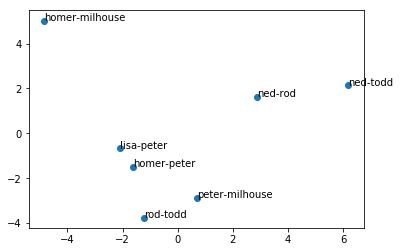

In [144]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.vstack(tuples)
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.scatter(result[:, 0], result[:, 1])
words = list(path_dict.keys())
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

## Create dendrogram for choosing the right number of clusters

In [130]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

#labelList = range(1, 11)

plt.figure(figsize=(10, 7))  
dendrogram(linked,  
            orientation='top',
            labels=words,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

IndexError: list index out of range

<Figure size 720x504 with 0 Axes>

## Define number of clusters depending on the dendogram

In [95]:
n = 6

## Clustering

#### Agglomerative Hierarchical clustering

In [96]:
from sklearn.cluster import AgglomerativeClustering

#labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
labels = words
agglo_clustering = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=n)
agglo_clustering.fit(X, labels)

agglo_clustering.labels_

array([0, 4, 5, 0, 2, 3, 1], dtype=int64)

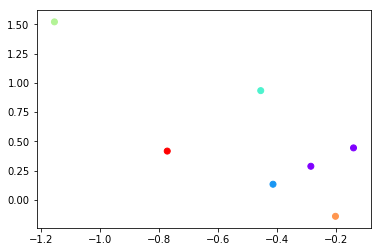

In [97]:
plt.scatter(X[:,0],X[:,1], c=agglo_clustering.labels_, cmap='rainbow')  

### Prediction

In [51]:
agglo_clustering.fit_predict(np.vstack(tuples[0]))

array([0, 1, 0, 0, 2, 1, 0, 1, 1, 3, 0, 1, 1, 0, 0, 0, 2, 2, 0, 1, 3, 3,
       2, 1, 0, 2, 2, 1, 0, 0, 1, 3, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2,
       3, 2, 2, 0, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 0, 2,
       1, 1, 0, 0, 0, 2, 0, 3, 0, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 0, 1, 3,
       0, 2, 2, 2, 2, 0, 1, 2, 3, 1, 0, 0, 2, 1, 2, 1, 3, 1, 2, 0, 2, 2,
       2, 3, 1, 0, 3, 2, 1, 2, 0, 1, 2, 2, 1, 3, 2, 3, 2, 2, 1, 2, 2, 1,
       2, 1, 2, 1, 2, 3, 1, 2, 0, 2, 2, 3, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1,
       2, 2, 0, 3, 3, 1, 0, 1, 2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 2, 2, 1, 1,
       1, 0, 1, 0, 2, 1, 2, 0, 3, 1, 0, 2, 2, 2, 1, 1, 2, 2, 3, 2, 0, 1,
       0, 2, 2, 2, 3, 2, 2, 3, 2, 0, 1, 2, 1, 2, 1, 1, 0, 3, 0, 0, 1, 1,
       0, 2, 2, 2, 0, 1, 1, 2, 1, 3, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2,
       1, 2, 2, 2, 0, 2, 0, 3, 2, 1, 0, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 1, 2, 0, 2, 1, 3, 0, 1, 0, 1, 0, 0, 3, 1, 3, 1, 1, 3, 0,
       0, 0, 0, 2, 2, 2, 1, 3, 0, 0, 2, 2, 1, 3], d